In [2]:
from coralModel import Reef
from coralModel import Organism
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import tools as tl

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

## Set Parameters

In [15]:
## What needs to be set
NumberOfSimulations = 100
dt=.1
tf=10


coralPercent = .5
algaePercent = .25
r=1.0
d=.2
a=.2
g=.5
y=.9
threshold = 5



rows = 10
columns = 10

## Set up based on above
NumberOfRuns = int(tf/dt)
turfPercent = 1 - coralPercent - algaePercent
NumberOfNodes = rows * columns
coralCount = np.zeros((NumberOfRuns, NumberOfSimulations))
turfCount = np.zeros((NumberOfRuns, NumberOfSimulations))
algaeCount = np.zeros((NumberOfRuns, NumberOfSimulations))
types = np.zeros((NumberOfRuns, NumberOfNodes, NumberOfSimulations))

In [42]:
Moorea = Reef()
count = 0
for i in range(0,rows):
    for j in range(0, columns):
        U = np.random.choice([0,1,2],
                             p=[coralPercent, turfPercent, algaePercent])
        node = Organism(type=U, location=[i,j], ID=count)
        Moorea.append(node)
        count = count + 1
Moorea.generateGraph(3)
    #NumberOfNodes = count

## Run model with new grid each run

In [16]:
for s in range(0,NumberOfSimulations):
#Generate square 8x8 reef with randomly assigned types
#0 = Coral, 1 = Turf, 2 = Algae
    Moorea = Reef()
    count = 0
    for i in range(0,rows):
        for j in range(0, columns):
            U = np.random.choice([0,1,2],
                                 p=[coralPercent, turfPercent, algaePercent])
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    Moorea.generateGraph(threshold)
    #NumberOfNodes = count

#Run model
    for n in range(0,NumberOfRuns):
        for i,val in enumerate(Moorea.nodes):
            types[n,i,s] = Moorea.nodes[i].type
        coralCount[n,s] = np.count_nonzero(types[n,:,s] == 0)
        turfCount[n,s] = np.count_nonzero(types[n,:,s] == 1)
        algaeCount[n,s] = np.count_nonzero(types[n,:,s] == 2)
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt)


In [43]:
Moorea.graph

{0: [0, 1, 2, 10, 11, 12, 20, 21, 22],
 1: [0, 1, 2, 3, 10, 11, 12, 13, 20, 21, 22, 23],
 2: [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24],
 3: [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25],
 4: [2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26],
 5: [3, 4, 5, 6, 7, 13, 14, 15, 16, 17, 23, 24, 25, 26, 27],
 6: [4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 24, 25, 26, 27, 28],
 7: [5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29],
 8: [6, 7, 8, 9, 16, 17, 18, 19, 26, 27, 28, 29],
 9: [7, 8, 9, 17, 18, 19, 27, 28, 29],
 10: [0, 1, 2, 10, 11, 12, 20, 21, 22, 30, 31, 32],
 11: [0, 1, 2, 3, 10, 11, 12, 13, 20, 21, 22, 23, 30, 31, 32, 33],
 12: [0,
  1,
  2,
  3,
  4,
  10,
  11,
  12,
  13,
  14,
  20,
  21,
  22,
  23,
  24,
  30,
  31,
  32,
  33,
  34],
 13: [1,
  2,
  3,
  4,
  5,
  11,
  12,
  13,
  14,
  15,
  21,
  22,
  23,
  24,
  25,
  31,
  32,
  33,
  34,
  35],
 14: [2,
  3,
  4,
  5,
  6,
  12,
  13,
  14,
  15,
  16,
  22,
  23,
  24,
  25,
  26,
  32,
  

## Plot averages, highs, and lows

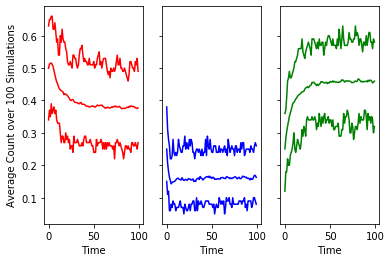

In [17]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, facecolor = 'w', sharey='row')
x = np.arange(NumberOfRuns)
im = ax.plot(x, coralCount.mean(axis=1)/NumberOfNodes, color='red')
im = ax.plot(x, coralCount.max(axis=1)/NumberOfNodes, color='red')
im = ax.plot(x, coralCount.min(axis=1)/NumberOfNodes, color='red')

im2 = ax2.plot(x, turfCount.mean(axis=1)/NumberOfNodes, color='blue')
im2 = ax2.plot(x, turfCount.max(axis=1)/NumberOfNodes, color='blue')
im2 = ax2.plot(x, turfCount.min(axis=1)/NumberOfNodes, color='blue')

im2 = ax3.plot(x, algaeCount.mean(axis=1)/NumberOfNodes, color='green')
im2 = ax3.plot(x, algaeCount.max(axis=1)/NumberOfNodes, color='green')
im2 = ax3.plot(x, algaeCount.min(axis=1)/NumberOfNodes, color='green')



ax.set_ylabel("Average Count over 100 Simulations")
ax.set_xlabel("Time")
ax2.set_xlabel("Time")
ax3.set_xlabel("Time")
ax.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

## Find where coral count gets lowest

In [18]:
## lowest value
np.max(coralCount[50:,:])

55.0

In [ ]:
## where it is located, ## run simlulation 
np.where(coralCount > 50)[1]

In [19]:
## step 71, 78, and 79 for simulation 37, 10, and 10
np.shape()

(100, 100)

## Plot Specific Simulations

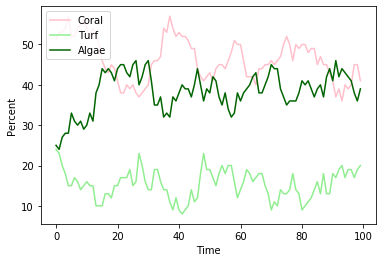

In [27]:
#Plotting progression over time for 1 simulation
x1=coralCount[:,71]
x2=turfCount[:,71]
x3=algaeCount[:,71]
tl.timeSeries(x, x1,x2,x3)

## Create animations of those simulations

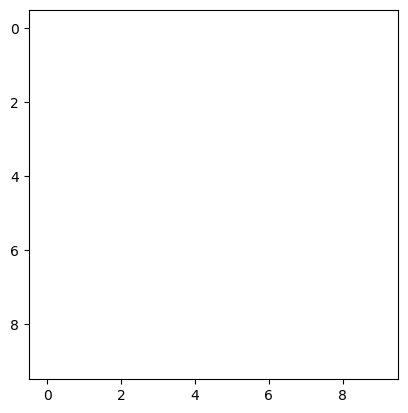

In [70]:
## create animations of those simulations
#%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure("Moving Wavepackage")
colors = ['pink', 'lightgreen','darkgreen']
levels = [0, 1, 2]
cmap, norm = clt.from_levels_and_colors(levels=levels,
                                        colors=colors, 
                                        extend='max')

Z   = []
img = []
for i in range(NumberOfRuns):
    Z.append(np.reshape(types[i,:,71], (-1, rows)))
    img.append([plt.imshow(Z[i], cmap=cmap, norm=norm)])

ani = animation.ArtistAnimation(fig, img, interval=200, blit=True, repeat_delay=0)

#HTML(ani.to_html5_video())

## Save Animation

In [71]:
## save animation
ani.save('./71.gif', writer='PillowWriter', fps=5)

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


## Save File

In [69]:
np.savetxt("modelOutput_shifting_71.csv", np.reshape(types[i,:,1], (-1, rows)), delimiter=",")

## Plotting inital and last spatial distribution of model runs

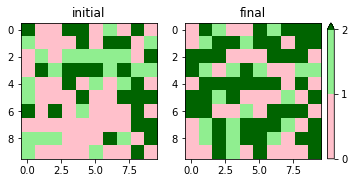

In [30]:
##initial
data1 = np.reshape(types[0,:,0], (-1, rows))
##final
data2 = np.reshape(types[NumberOfRuns-1,:,0], (-1, rows))
##plot
tl.initialFinal(data1=data1, data2=data2) 

In [ ]:
x = np.arange(NumberOfRuns)
ylabel = "Average Count over 100 Simulations"
#plot
tl.averageHists(x, coralCount, turfCount, algaeCount, ylabel) 

# Begin TDA

#### Steps
* Set values to 1 = Coral, 0 = Other
* create a finer grid
* use gaussians at each node to create variation based on overlap
* Do TDA on output 


In [56]:
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import ndimage
import PIL
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition 

### Make Binary (including inverse (i)) and refine grid

In [62]:
tester, testeri = tl.tda_prep(types[0,:,71], columns, rows, 8, True)

In [47]:
types[0,:,2]

array([0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 2., 2., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 2., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2., 2.,
       2., 2., 1., 0., 2., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1.,
       1., 2., 0., 0., 2., 1., 1., 1., 0., 0., 2., 1., 0., 1., 1., 0., 2.,
       0., 0., 2., 2., 1., 2., 1., 0., 2., 2., 1., 2., 0., 0., 0.])

In [46]:
tester

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

### Add texture (empasize larger patches)

In [63]:
yo = ndimage.distance_transform_edt(tester)
yoi = ndimage.distance_transform_edt(testeri)

### Run TDA
RE [Ripser](https://ripser.scikit-tda.org/Lower%20Star%20Image%20Filtrations.html) approach

In [64]:
prep = tl.prep2(yo)
prepi = tl.prep2(yoi)

#RUN Lower Star Algorithm
dgm = lower_star_img(-prep)
dgmi = lower_star_img(-prepi)


In [65]:
#Grab points above a threshold
threshold = 4
points = tl.pointDef(dgm, threshold)
pointsi = tl.pointDef(dgmi, threshold)



In [66]:
### can already grab number of patches here with 
points.shape[0]

4

### Plot output

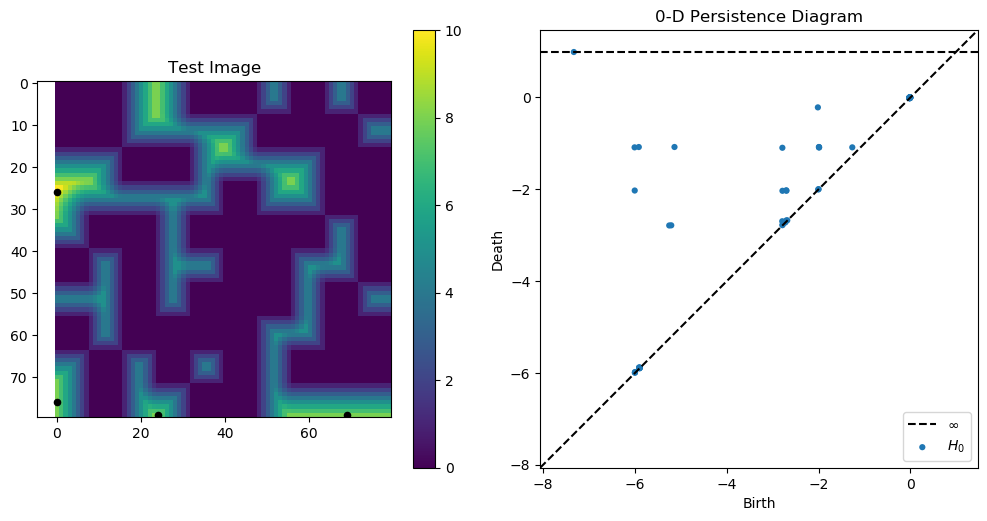

In [67]:
tl.plotTDA(points, yo, prep, dgm)

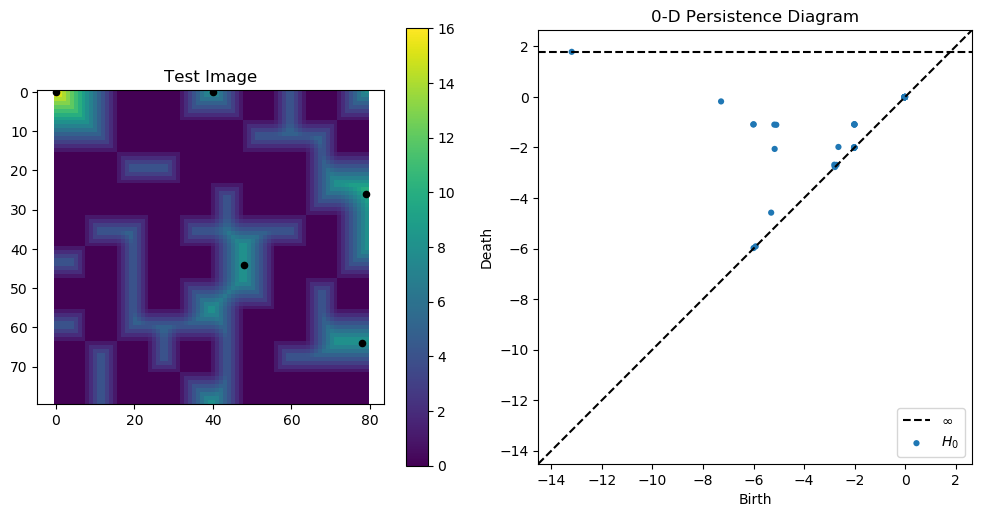

In [68]:
tl.plotTDA(pointsi, yoi, prepi, dgmi)

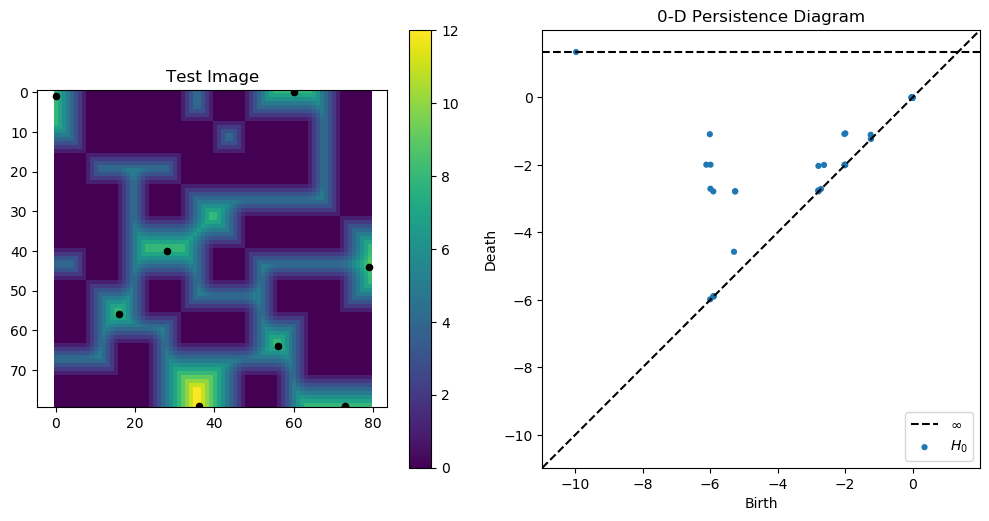

In [57]:
tester, testeri = tl.tda_prep(types[0,:,1], columns, rows, 8, True)
yo = ndimage.distance_transform_edt(tester)
yoi = ndimage.distance_transform_edt(testeri)
prep = tl.prep2(yo)
prepi = tl.prep2(yoi)

#RUN Lower Star Algorithm
dgm = lower_star_img(-prep)
dgmi = lower_star_img(-prepi)

#Grab points above a threshold
threshold = 2
points = tl.pointDef(dgm, threshold)
pointsi = tl.pointDef(dgmi, threshold)

tl.plotTDA(points, yo, prep, dgm)

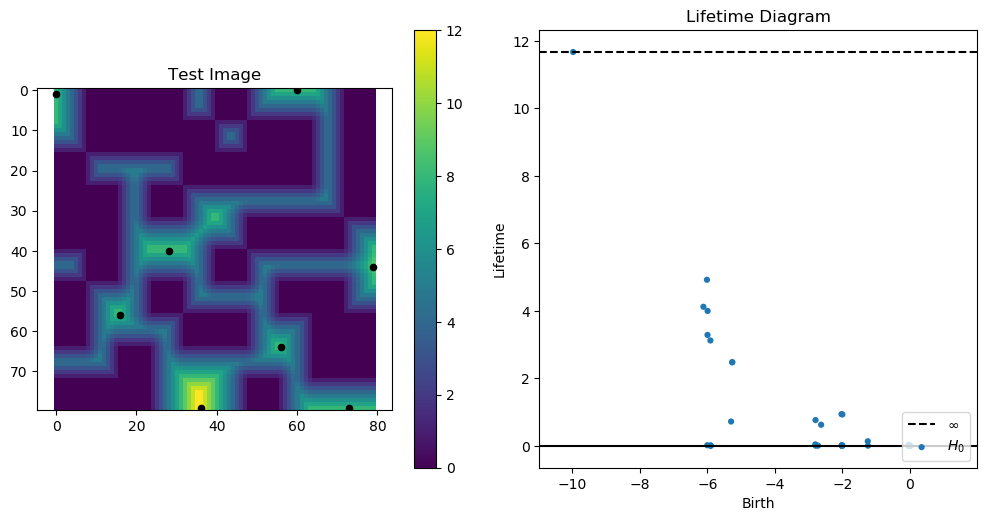

In [61]:
def plotPoints(points, df, dgm):
    X, Y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))
    X = X.flatten()
    Y = Y.flatten()
    for idx in points:
        bidx = np.argmin(np.abs(df + dgm[idx, 0]))
        plt.scatter(X[bidx], Y[bidx], 20, 'k')
        
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(yo)
plt.colorbar()
plotPoints(points, prep, dgm)
plt.title("Test Image")
plt.subplot(122)
plot_diagrams(dgm, lifetime=True)
plt.title("Lifetime Diagram")

plt.tight_layout()
plt.show()

In [ ]:
tl.plotTDA(pointsi, yoi, prepi, dgmi)

--------

--------

--------

--------

--------

In [ ]:
NumberOfRuns = 100
NumberOfSimulations = 100
coralPercent = .5
algaePercent = .25
turfPercent = 1 - coralPercent - algaePercent
r=1.0
d=.4
a=.2
g=.3
y=.75
dt=.01

rows = 50
columns = 50

NumberOfNodes = rows * columns
coralCount = np.zeros((NumberOfRuns, NumberOfSimulations))
turfCount = np.zeros((NumberOfRuns, NumberOfSimulations))
algaeCount = np.zeros((NumberOfRuns, NumberOfSimulations))
types = np.zeros((NumberOfRuns, NumberOfNodes, NumberOfSimulations))

In [ ]:
#0 = Coral, 1 = Turf, 2 = Algae
Moorea = Reef()
count = 0
for i in range(0,rows):
    for j in range(0, columns):
        U = np.random.choice([0,1,2],
                             p=[coralPercent, turfPercent, algaePercent])
        node = Organism(type=U, location=[i,j], ID=count)
        Moorea.append(node)
        count = count + 1
Moorea.generateGraph()

In [ ]:
for s in range(0,NumberOfSimulations):    
    for n in range(0,NumberOfRuns):
        for i,val in enumerate(Moorea.nodes):
            types[n,i,s] = Moorea.nodes[i].type
        coralCount[n,s] = np.count_nonzero(types[n,:,s] == 0)
        turfCount[n,s] = np.count_nonzero(types[n,:,s] == 1)
        algaeCount[n,s] = np.count_nonzero(types[n,:,s] == 2)
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt)

--------

--------

Proximity of Patches less relevant? looking at neighbour relations, not global